## Summary

The remittance prices for \$200 (cc1) and \$500 (cc2) are strongly positively correlated but in general cc2 tends to be lower, see the [plot](#remplot) for cc2-cc1. 

I first focused on the effects of corridor and time. Let's look at the [plots](#toindia) of sending to India. There is a downward trend even though sending from Australia is more onerous than from Italy. I thus decided to look at the time trend per channel to quantify: How much, per day, remittance prices went up or down?

The task can be accomplished [regressing prices](#corridorreg) (I just focused on cc1 as cc2 is strongly correlated to it) on the number of days from the earliest date in the dataset. The coefficient of time can be either significantly positive (prices went up) or significantly negative (prices went down) or not significant (we can safely bet is zero). Since I ran multiple tests, I controlled the false discovery rate at 5% (reporting a significant coeffient when is not) via Bonferroni. [Here](#corridorsum) you can find the results: 62% of the trends are significant and 19% of the times prices went up. You can also find rankings of channels and a [plot](#coefdistro) of the distribution of coefficients.

Then I looked at trends across regions. Note: only 8% of the observations are complete here. To improve the analysis one should go through countries and assign regions to each of them. [Here](#aggreg) you can find a summary of prices across these regional corridors, and [here](#regsum) a summary of time trends: prices went down the most in East Asia & Pacific->East Asia & Pacific and up the most in Europe & Central Asia->Europe & Central Asia.

I then looked at the channel medium: Bank, Money Transfer Operator, Post Office... [Here](#opsum) a summary of the percentage of events and prices per channel. Bank and Money Transfer make about 96% of the data (we don't know about market share though, but should be large) and Money Transfer is less expensive. I decided to [compare costs](#costcomparison) of Bank and Money transfer between 2011 and 2015 (we don't have all 2016). I used a ttest to obtain confidence intervals for the change in prices: I estimated that Bank went down of about 14% and Money Transfer of about 12%.

Finally I focused on predictors of remittance prices. For numerical variables I looked at [correlations](#corrplot): we see that cc1 and cc2 are strongly positively correlated, and lcu.amount, lcu.fee and fx.margin are positively correlated with prices. On the other hand, time is slightly negatively correlated indicating an overall downward trend. 

To measure association with categorial variables, I used the [mutual information](#mutinfo): this measures the mutual dependence between two variables. When it is 0 we can assume independence. In the table I have ranked variables by their effect on cc1: top is the corridor, next 5 can be deduced from the corridor, then product, firm_type, source_lending and speed.

In [1]:
require(gdata)
require(dplyr)
require(ggplot2)
require(corrplot)
require(entropy)

Loading required package: gdata
gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: 'gdata'

The following object is masked from 'package:stats':

    nobs

The following object is masked from 'package:utils':

    object.size

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:gdata':

    combine, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Warning message:
: package 'ggplot2' was built under R version 3.2.4Loading required package: corrplot
Warning message:
: package 'corrplot' was built under R version 3.2.5Loading required package: entropy


## Read Excel into R and save to csv

In [11]:
dfQ1 <- read.xls('rpw_dataset_2011_2016_q2.xlsx', sheet=5,header=T, na.strings = '..', stringsAsFactors = F)

In [13]:
write.csv(dfQ1, row.names = FALSE, file = 'dfQ1.csv')

In [14]:
dfQ2 <- read.xls('rpw_dataset_2011_2016_q2.xlsx', sheet=6,header=T, na.strings = '..', stringsAsFactors = F)

In [16]:
write.csv(dfQ2, row.names = FALSE, file = 'dfQ2.csv')

In [17]:
dfCountry <- read.xls('rpw_dataset_2011_2016_q2.xlsx', sheet=4,header=T, na.strings = '..', stringsAsFactors = F)

In [22]:
names(dfCountry) <- dfCountry[1,]
dfCountry <- dfCountry[-1,]

In [24]:
write.csv(dfCountry, row.names = FALSE, file = 'dfCountry.csv')

## Merging Q1 & Q2

In [33]:
dfQ1$payment.instrument <- NA
dfQ1$sending.network.coverage <- NA
dfQ1$cash.pickup.location <- NA
dfQ2$product <- NA
names(dfQ1)[which(names(dfQ1) == 'coverage')] <- 'receiving.network.coverage'
names(dfQ1)[which(names(dfQ1) == 'pick.up.method')] <- 'receiving.method'
names(dfQ2)[which(names(dfQ2) == 'access.point')] <- 'sending.location'
dfAll <- rbind(dfQ1,dfQ2)

In [41]:
# Reformat & Extract Date Info
cc <- dfAll$date
Day <- sapply(cc, function(x) substr(x, 1,2))
Month <- sapply(cc, function(x) substr(x, 4,6))
Year <- sapply(cc,function(x) substr(x, 8,11))
    
MonthMask <- c(paste0('0',c(1:9)),10,11,12)
names(MonthMask) <- c('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec')
Month <- MonthMask[Month]
    
dfAll$day <- Day
dfAll$month <- as.numeric(Month)
dfAll$year <- Year
    
NewDate <- paste(Year,Month,Day, sep = '-')
dfAll$weekday <- format(as.POSIXct(NewDate, format = '%Y-%m-%d'),'%a')
dfAll$weekno <- format(as.POSIXct(NewDate, format = '%Y-%m-%d'),'%U')
    
dfAll$date <- NewDate

In [42]:
write.csv(dfAll, row.names = FALSE, file = 'dfAll.csv')

## Corridor vs Time

First I look at cc2 vs cc1; cc2 should be less expensive than cc1 because we move more money. This is confirmed by the distribution plot and computing means.

In [2]:
dfAll <- read.csv('dfAll.csv', header = T, stringsAsFactors = F) # Could not work on this in one time-block
names(dfAll)[which(names(dfAll) == 'cc1.total.cost..')] <- 'cc1'
names(dfAll)[which(names(dfAll) == 'cc2.total.cost..')] <- 'cc2'

# aggregate by date & corridor
dfAgg <- dfAll %>% group_by(date, corridor) %>% mutate(cc1 = mean(cc1),
                                                          cc2 = mean(cc2)) %>% ungroup()

Warning message:
In FUN(X[[i]], ...): failed to assign NativeSymbolInfo for env since env is already defined in the 'lazyeval' namespace

<a id='remplot'></a>

Warning message:
: Removed 198 rows containing non-finite values (stat_density).

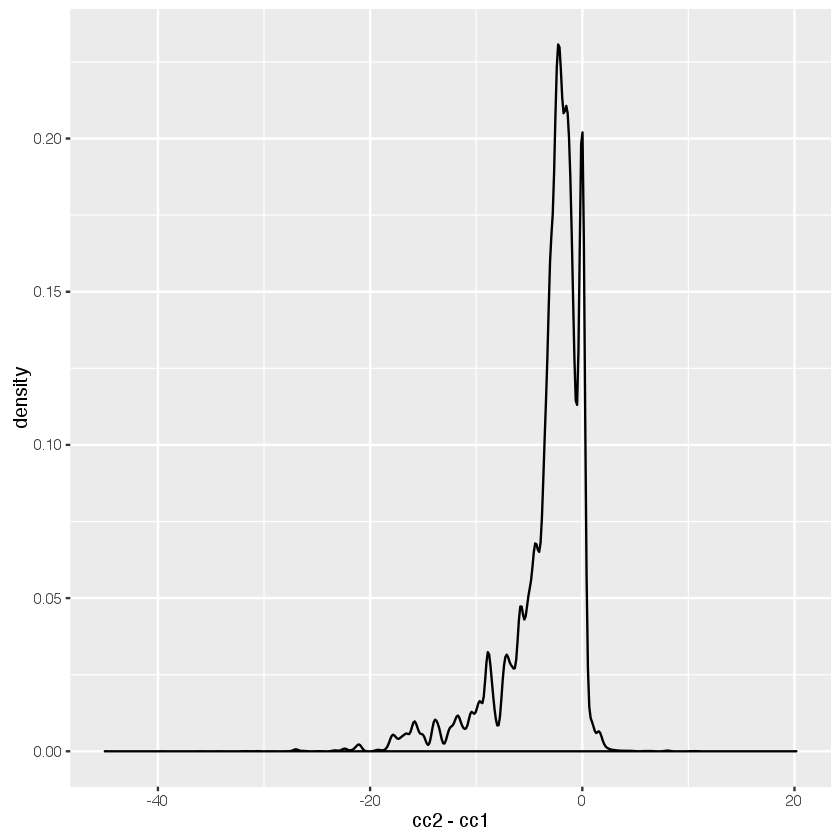

In [3]:
ggplot(dfAll, aes(cc2-cc1)) + geom_density()

In [4]:
mean(dfAll$cc1)
mean(dfAll$cc2, na.rm = T)
with(dfAll, mean(cc1>cc2, na.rm = T)) # probability that cc1 exceeds cc2

[1] 8.334993

[1] 5.010729

[1] 0.8798075

Let's look at cost of sending money to Indian from AUS, IT, GB, US

<a id='toindia'></a>

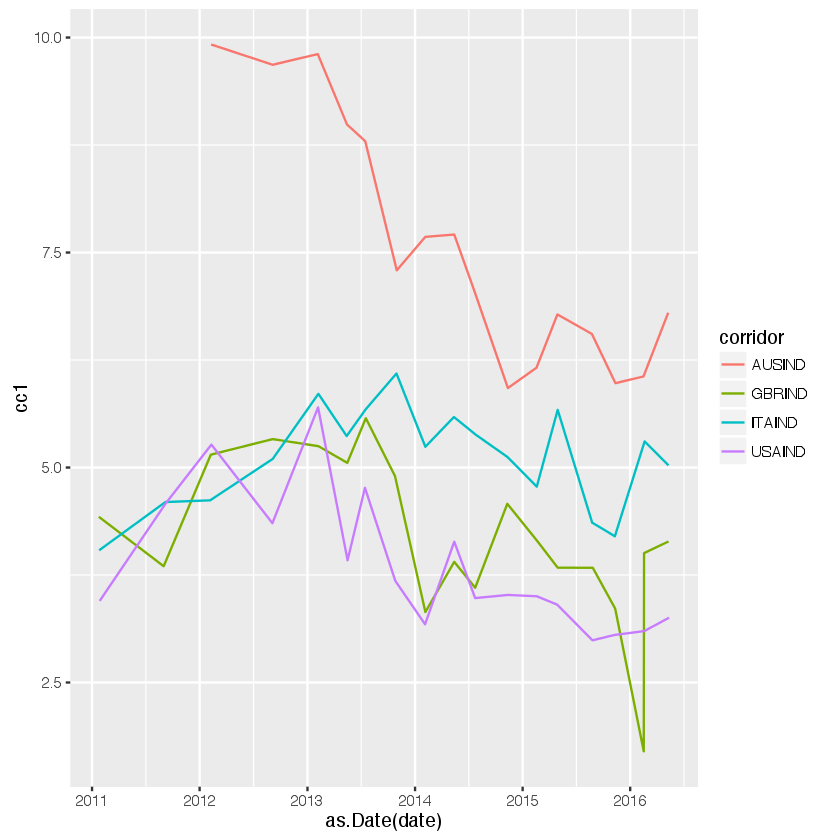

In [5]:
ggplot(dfAgg %>% filter(corridor %in% c('AUSIND', 'GBRIND', 'ITAIND', 'USAIND')), 
       aes(x=as.Date(date), y=cc1)) + geom_line(aes(colour=corridor))

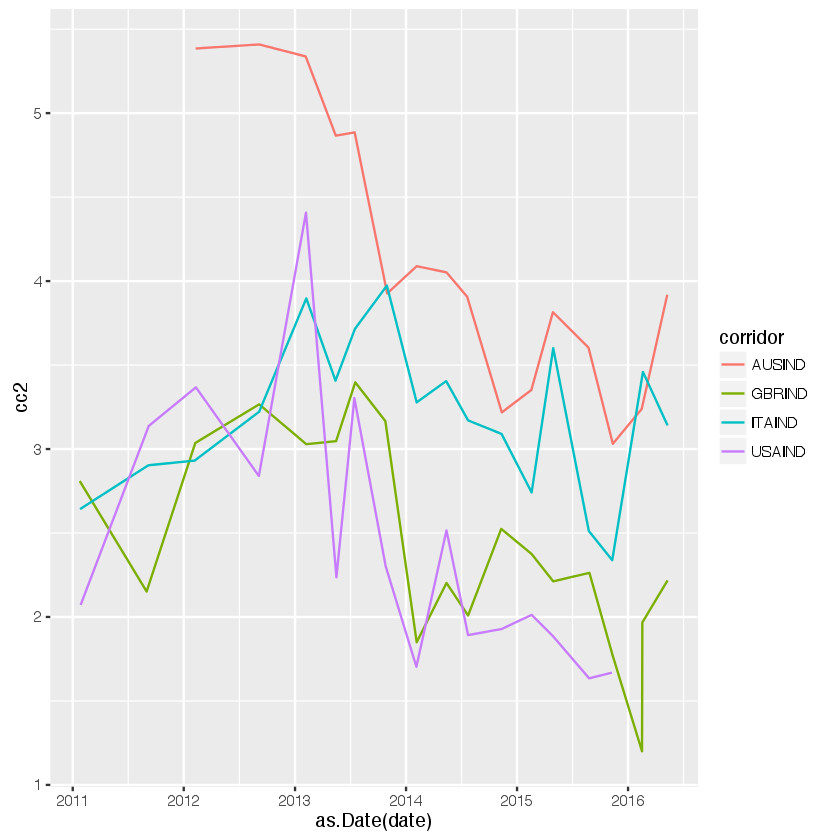

In [6]:
ggplot(dfAgg %>% filter(corridor %in% c('AUSIND', 'GBRIND', 'ITAIND', 'USAIND')), 
       aes(x=as.Date(date), y=cc2)) + geom_line(aes(colour=corridor))

Prices have been going down but differ by corridor. Is there a downward trend across all corridors?

In [7]:
# create time variable as difference of days from minimal date
cc <- unique(dfAll$date)
MinDate <- min(cc)
ddiff <- difftime(as.Date(cc), as.Date(MinDate), units='days')
DateMask <- data.frame(date = cc, time = as.numeric(ddiff))

In [8]:
dfAll <- dfAll %>% merge(DateMask, by='date')
dfAgg <- dfAgg %>% merge(DateMask, by = 'date')

For trends I will follow a standard boiler plate to save time. 
I isolate corridors and then I regress on time using lm; then pull out the time coefficients and its p-value; I will look only when the time coefficient is different from 0; since I am testing multiple hypotheses will use Bonferroni method to control the false discovery rate (divide the pval / # of tests I am doing). In this way the percentage of trends that are falsely deemed significant should be < 5%.
Note: sometimes the fit looked suspiciously good or a warning was issued, so I am throwing away results where the R.squared > 0.80. With more time one can look at what is happening in these cases

<a id='corridorreg'></a>

In [9]:
Corridors <- unique(dfAgg$corridor)
clModels <- list()
for(i in Corridors) {
    print(i)
    mySummary <- summary(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == i)))
    if(!is.null(mySummary))
        clModels[[i]] <- mySummary
}

[1] "ARELKA"
[1] "ARENPL"
[1] "ZAFBWA"
[1] "FRATUN"
[1] "ZAFLSO"
[1] "ZAFZWE"
[1] "ZAFZMB"
[1] "ZAFSWZ"
[1] "FRAMAR"
[1] "ZAFMWI"
[1] "ZAFMOZ"
[1] "ZAFAGO"
[1] "FRACIV"
[1] "FRAMLI"
[1] "AREIND"
[1] "FRASEN"
[1] "AREEGY"
[1] "AREPAK"
[1] "QATPHL"
[1] "AUSFJI"
[1] "AUSKIR"
[1] "AUSPAK"
[1] "AUSPNG"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "AUSWSM"
[1] "AUSSLB"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "AUSTON"
[1] "AUSTUV"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "AUSVUT"
[1] "AUSVNM"
[1] "FRAVNM"
[1] "JPNPHL"
[1] "KORCHN"
[1] "DEUCHN"
[1] "BRABOL"
[1] "BRAPRY"
[1] "BRAPER"
[1] "CANHTI"
[1] "TZARWA"
[1] "TZAUGA"
[1] "SAUYEM"
[1] "MYSPHL"
[1] "DEUMAR"
[1] "FRACHN"
[1] "USANGA"
[1] "GBRCHN"
[1] "NLDMAR"
[1] "NLDANT"
[1] "NLDNGA"
[1] "AREPHL"
[1] "NLDTUR"
[1] "QATIND"
[1] "GBRIND"
[1] "GBRJAM"
[1] "GBRBGD"
[1] "GBRBRA"
[1] "JPNIND"
[1] "USAVNM"
[1] "JPNKOR"
[1] "GBRPAK"
[1] "FRAIND"
[1] "USACHN"
[1] "USAGHA"
[1] "TZAKEN"
[1] "NLDDOM"
[1] "NLDSUR"
[1] "SAUJOR"
[1] "GBRRWA"
[1] "ITASRB"
[1] "ESPPER"
[1] "ITAPHL"
[1] "ITABRA"
[1] "DEUSRB"
[1] "FRAHTI"
[1] "ESPCHN"
[1] "ESPDOM"
[1] "ESPCOL"
[1] "GBRNGA"
[1] "ESPBGR"
[1] "ITANGA"
[1] "SAUBGD"
[1] "JPNBRA"
[1] "KORVNM"
[1] "RUSAZE"
[1] "USAPAK"
[1] "ESPPHL"
[1] "ITALKA"
[1] "RUSARM"
[1] "GBRSLE"
[1] "ITAALB"
[1] "NZLKIR"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ITACHN"
[1] "GBRBGR"
[1] "NZLPNG"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "MYSIDN"
[1] "NZLFJI"
[1] "ITAMAR"
[1] "NZLTON"
[1] "NZLTUV"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "USAPAN"
[1] "ITAROU"
[1] "ITAETH"
[1] "GBRGHA"
[1] "ESPBRA"
[1] "ITAIND"
[1] "RUSBLR"
[1] "ESPECU"
[1] "FRADZA"
[1] "NZLWSM"
[1] "NZLSLB"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ESPMAR"
[1] "GBRPHL"
[1] "GBRGMB"
[1] "SAUEGY"
[1] "SAUIND"
[1] "GBRALB"
[1] "USABRA"
[1] "USAPER"
[1] "ESPHND"
[1] "USANIC"
[1] "SGPPAK"
[1] "CZEUKR"
[1] "GBRLKA"
[1] "NZLVUT"
[1] "ITAMDA"
[1] "RUSEST"
[1] "USACOL"
[1] "USAGTM"
[1] "ESPROU"
[1] "JPNCHN"
[1] "CANIND"
[1] "NLDGHA"
[1] "CANRWA"
[1] "USADOM"
[1] "SGPPHL"
[1] "CRINIC"
[1] "USAECU"
[1] "CANPHL"
[1] "CZEVNM"
[1] "CANVNM"
[1] "GBRZMB"
[1] "USAPHL"
[1] "GBRKEN"
[1] "DEULBN"
[1] "GBRNPL"
[1] "USAIDN"
[1] "SAUNPL"
[1] "USAGUY"
[1] "RUSKGZ"
[1] "SAUPHL"
[1] "USATHA"
[1] "SGPCHN"
[1] "RUSGEO"
[1] "RUSKAZ"
[1] "CHLPER"
[1] "GBRLTU"
[1] "USAHND"
[1] "CANJAM"
[1] "GBRUGA"
[1] "GHANGA"
[1] "DEUROU"
[1] "RUSLTU"
[1] "USAHTI"
[1] "RUSLVA"
[1] "USALBN"
[1] "RUSMDA"
[1] "GBRZAF"
[1] "USAMEX"
[1] "USASLV"
[1] "MYSBGD"
[1] "GBRPOL"
[1] "USAIND"
[1] "SGPMYS"
[1] "GBRETH"
[1] "GBRERI"
[1] "SGPIDN"
[1] "USAJAM"
[1] "GBRZWE"
[1] "DOMHTI"
[1] "SGPTHA"
[1] "NORPAK"
[1] "SGPIND"
[1] "DEUIND"
[1] "DEUHRV"
[1] "BELMAR"
[1] "BELTUR"
[1] "SGPBGD"

Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "CHEHUN"
[1] "CHEKSV"
[1] "DEUBGR"
[1] "DEUKGZ"
[1] "DEUTJK"
[1] "CHEALB"
[1] "AREIDN"
[1] "AREJOR"
[1] "QATLKA"
[1] "QATSDN"
[1] "DEUMKD"
[1] "USAAFG"
[1] "USABGD"
[1] "USACRI"
[1] "USAEGY"
[1] "USAZAF"
[1] "AUSLKA"
[1] "FRACMR"
[1] "THAMMR"
[1] "MYSNPL"
[1] "AUSZWE"
[1] "AUSTHA"
[1] "FRASRB"
[1] "MYSMMR"
[1] "THALAO"
[1] "FRAMDG"
[1] "GBRAFG"
[1] "CANPAK"
[1] "FRALBN"
[1] "ESPBOL"
[1] "MYSIND"
[1] "MYSCHN"
[1] "GBRTHA"
[1] "THAKHM"
[1] "CANLKA"
[1] "CANNGA"
[1] "SAULKA"
[1] "SAUMMR"
[1] "SAUSDN"
[1] "SAUSYR"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "USAARM"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "AUSMYS"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "GBRLBN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "SAUSSD"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "USAERI"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "USANPL"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "GBRVNM"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "SAULBN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "USASSD"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ISRMAR"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ITATUN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "NGABEN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "NGAMLI"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "NGATGO"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "KENSSD"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ITAECU"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "SWECHN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "SWEIND"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "SWELBN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "AGONAM"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "JOREGY"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "JORSYR"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ZAFNGA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "KWTJOR"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "KWTPAK"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ZAFCHN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "CMRNGA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "TURBGR"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "KWTPHL"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "CIVMLI"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "INDPAK"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "INDLKA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "INDNPL"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "THAVNM"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "THAIND"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "THAIDN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "RWAKEN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "THACHN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "INDBGD"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "PRTMOZ"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "GBRSSD"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ARESSD"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "JORPSE"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "PRTBRA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "PRTCPV"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "DEUHUN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "PAKBGD"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ARESDN"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "BELDZA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "PAKAFG"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "OMNNPL"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "MYSVNM"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "OMNJOR"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "ESPNGA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "OMNPAK"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "OMNLKA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "FRACOM"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "MYSTHA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "DEUTHA"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "OMNBGD"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "OMNIND"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "BHRIND"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "BHREGY"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "BHRPAK"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

[1] "USACUB"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfAgg %>% filter(corridor == : essentially perfect fit: summary may be unreliable

In [10]:
trends <- data.frame(corridor = names(clModels))
trends$coef <- NA
trends$pval <- NA
trends$r.squared <- NA
for(i in 1:dim(trends)[1]) {
    try(
        {Corridor <- trends[i,'corridor']
        trends[i, 'coef'] <- clModels[[Corridor]][['coefficients']][2,1]
        trends[i, 'pval'] <- clModels[[Corridor]][['coefficients']][2,4]
        trends[i, 'r.squared'] <- clModels[[Corridor]][['r.squared']]},
        silent = T)
    }

In [11]:
trends <- trends %>% filter(r.squared < 0.80 & !is.na(coef))
trends <- trends %>% mutate(sig = pval < 0.05/dim(trends)[1])

Top 10 channels where prices went down/up the most.

<a id='corridorsum'></a>

In [12]:
head(trends %>% filter(sig == 1) %>% arrange(coef))

,corridor,coef,pval,r.squared,sig
1,NZLVNM,-0.0140358016338256,5.34003408135284e-12,0.699527684751395,1
2,NLDSOM,-0.00673727770036334,2.77228459209858e-36,0.626759364294415,1
3,GBRVNM,-0.00649066058600972,1.29248724646356e-07,0.319156173606633,1
4,ITASEN,-0.00641877421759049,6.84143501116688e-55,0.604426775043331,1
5,NZLTUV,-0.00455071031952941,1.42586691542926e-09,0.63300911583319,1
6,FRACMR,-0.0038953496839596,5.0128650965409e-66,0.522479415752188,1


In [13]:
tail(trends %>% filter(sig == 1) %>% arrange(coef))

,corridor,coef,pval,r.squared,sig
163,SGPPHL,0.00484985070433056,7.89893848687562e-05,0.380663317267223,1
164,SGPMYS,0.00638156837538167,3.10497286476307e-05,0.607680865145006,1
165,SAUYEM,0.00710214883492114,3.50393158749114e-07,0.584574082501444,1
166,RUSUKR,0.0078007545292484,4.65522571310276e-05,0.732853340882075,1
167,SAUEGY,0.00927242911113879,1.68771880954141e-05,0.695782652557521,1
168,SAULBN,0.0168600883843293,1.19137811022176e-05,0.756718570771627,1


What is the percentage of channels where price went up? Summarize distros

In [80]:
mean(trends$sig)

[1] 0.6199262

In [51]:
with(trends %>% filter(sig == 1), mean(coef>0))

[1] 0.1964286

<a id='coefdistro'></a>

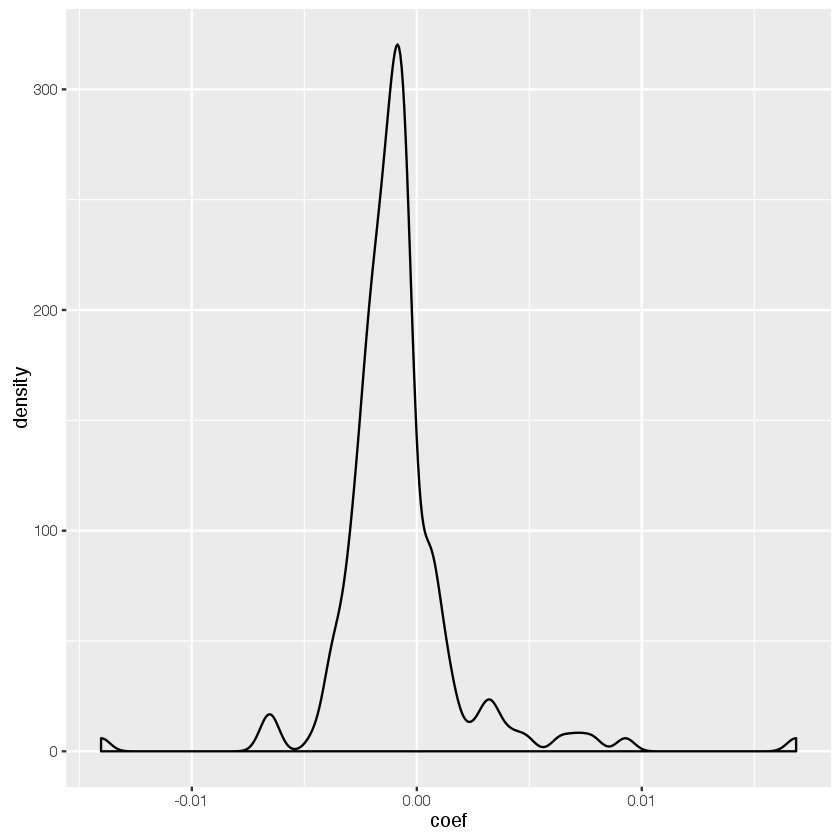

In [52]:
ggplot(trends %>% filter(sig == 1), aes(coef)) + geom_density()

## Regional Corridors vs Time

I repeat the previous analysis for regional corridors: e.g. East Asia -> South East Asia

In [14]:
with(dfAll,mean(!is.na(destination_region) & !is.na(source_region)))

[1] 0.08496891

<a id='aggreg'></a>

In [56]:
dfRegion <- dfAll %>% filter(!is.na(destination_region) & !is.na(source_region))
dfRegion$rcorridor <- with(dfRegion, paste(source_region, destination_region, sep = '->'))
RcorridorStats <- dfRegion %>% group_by(rcorridor) %>% 
        summarize(n()/dim(dfRegion)[1], mean(cc1,na.rm=T), mean(cc2,na.rm=T))
RcorridorStats 

,rcorridor,n()/dim(dfRegion)[1],"mean(cc1, na.rm = T)","mean(cc2, na.rm = T)"
1,East Asia & Pacific->East Asia & Pacific,0.160458452722063,6.43585164835165,3.94718309859155
2,East Asia & Pacific->South Asia,0.076261847035486,5.12592485549133,3.46308157099698
3,Europe & Central Asia->Europe & Central Asia,0.00220409962530306,11.352,9.47
4,Latin America & Caribbean->Latin America & Caribbean,0.1796341194622,6.21501840490798,4.94364532019704
5,Middle East & North Africa->Middle East & North Africa,0.0035265594004849,5.768125,3.060625
6,South Asia->South Asia,0.00749393872603042,6.33264705882353,2.57882352941176
7,Sub-Saharan Africa->East Asia & Pacific,0.00176327970024245,21.15375,13.485
8,Sub-Saharan Africa->South Asia,0.0033061494379546,11.8853333333333,8.00666666666667
9,Sub-Saharan Africa->Sub-Saharan Africa,0.565351553890236,16.5913996101365,9.34587854251012


Only 9 combinations; not all corridors have the same number of events; I create a numerical index to plot only some of them

In [57]:
RcorridorMask <- c(1:9)
names(RcorridorMask) <- RcorridorStats$rcorridor
dfRAgg <- dfRegion %>% mutate(frcorridor=as.factor(RcorridorMask[rcorridor])) %>% 
                                            group_by(rcorridor, date) %>% mutate(cc1 = mean(cc1),
                                                          cc2 = mean(cc2))%>% ungroup()

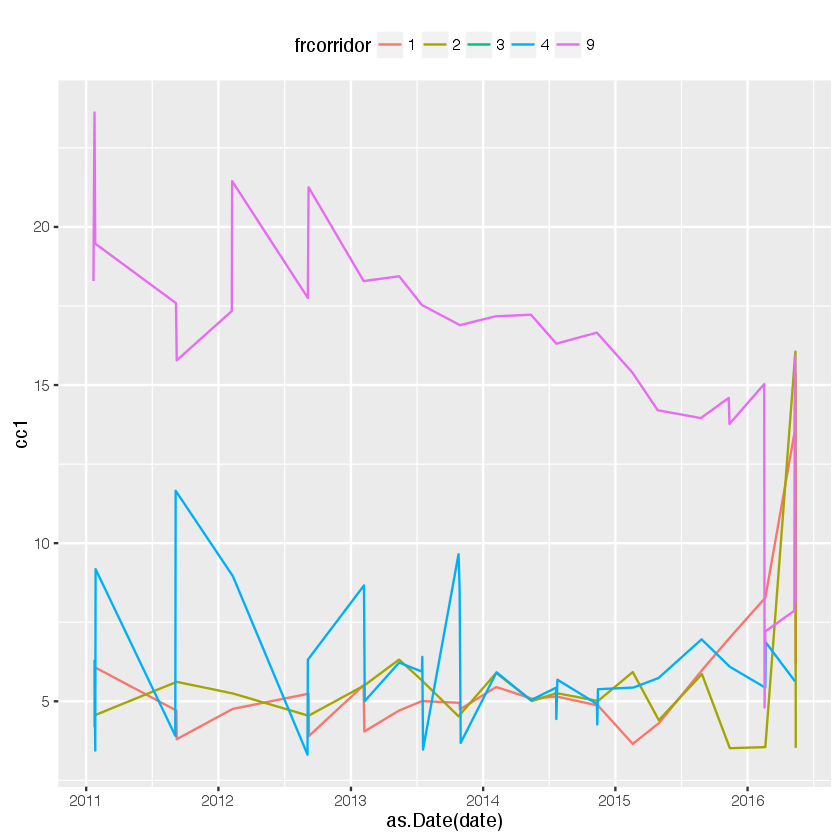

In [59]:
ggplot(dfRAgg %>% filter(frcorridor %in% c(1,2,3,4,9)),
       aes(x=as.Date(date),y=cc1)) + geom_line(aes(colour=frcorridor)) + theme(legend.position='top')

In [60]:
RCorridors <- unique(dfRAgg$rcorridor)
RclModels <- list()
for(i in RCorridors) {
    print(i)
    mySummary <- summary(lm(cc1 ~ time, data = dfRAgg %>% filter(rcorridor == i)))
    if(!is.null(mySummary))
        RclModels[[i]] <- mySummary
}

[1] "Sub-Saharan Africa->Sub-Saharan Africa"
[1] "Latin America & Caribbean->Latin America & Caribbean"
[1] "East Asia & Pacific->East Asia & Pacific"
[1] "East Asia & Pacific->South Asia"
[1] "Sub-Saharan Africa->South Asia"
[1] "Middle East & North Africa->Middle East & North Africa"
[1] "Sub-Saharan Africa->East Asia & Pacific"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfRAgg %>% filter(rcorridor == : essentially perfect fit: summary may be unreliable

[1] "Europe & Central Asia->Europe & Central Asia"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfRAgg %>% filter(rcorridor == : essentially perfect fit: summary may be unreliable

[1] "South Asia->South Asia"


Warning message:
In summary.lm(lm(cc1 ~ time, data = dfRAgg %>% filter(rcorridor == : essentially perfect fit: summary may be unreliable

In [61]:
Rtrends <- data.frame(rcorridor = names(RclModels))
Rtrends$coef <- NA
Rtrends$pval <- NA
Rtrends$r.squared <- NA
for(i in 1:dim(Rtrends)[1]) {
    try(
        {Corridor <- Rtrends[i,'rcorridor']
        Rtrends[i, 'coef'] <- RclModels[[Corridor]][['coefficients']][2,1]
        Rtrends[i, 'pval'] <- RclModels[[Corridor]][['coefficients']][2,4]
        Rtrends[i, 'r.squared'] <- RclModels[[Corridor]][['r.squared']]},
        silent = T)
    }

In [62]:
Rtrends <- Rtrends %>% filter(r.squared < 0.80 & !is.na(coef))
Rtrends <- Rtrends %>% mutate(sig = pval < 0.05/dim(Rtrends)[1])

<a id='regsum'></a>

In [63]:
Rtrends

,rcorridor,coef,pval,r.squared,sig
1,Latin America & Caribbean->Latin America & Caribbean,-6.13390991286266e-05,0.788750050929387,0.000208969720123476,0
2,East Asia & Pacific->East Asia & Pacific,-0.00276281102921112,0,0.605897901349776,1
3,East Asia & Pacific->South Asia,-0.000817260768126849,1.8143499064364e-13,0.0645268234369591,1
4,Middle East & North Africa->Middle East & North Africa,-0.00699761516753447,0.0137909901033501,0.383695993298119,0
5,Europe & Central Asia->Europe & Central Asia,0.00286489453006438,2.12192428721077e-63,0.322539246616647,1


Price went down the most on East Asia & Pacific->East Asia & Pacific (corridor 4 not significant) and up in Europe & Central Asia->Europe & Central Asia

## Trends by sending channel 

We now aggregate by firm_type to understand the effect of sending channels

In [64]:
# type of firms
unique(dfAll$firm_type) # -> note the missing value ''

[1] "Money Transfer Operator"                   
 [2] "Bank"                                      
 [3] "Money Transfer Operator / Post office"     
 [4] "Post office"                               
 [5] "Non-Bank FI"                               
 [6] "Money Transfer Operator / Building Society"
 [7] "Bank/Post office"                          
 [8] "Bank / Money Transfer Operator"            
 [9] "Credit Union"                              
[10] ""

In [65]:
dfAll[dfAll$firm_type=='','firm_type'] <- 'Missing'

Let's look at channel's share of the market (rough measure: just look at # of rows)

<a id='opsum'></a>

In [66]:
dfAll %>% group_by(firm_type) %>% summarize(cc1=mean(cc1),cc2=mean(cc2,na.rm=T),perc=n()/dim(dfAll)[1]) %>% 
    arrange(desc(perc))
                                            

,firm_type,cc1,cc2,perc
1,Money Transfer Operator,6.74320965361721,4.54841232943845,0.696119559517567
2,Bank,12.5498877920602,6.19989702435906,0.263708892051839
3,Money Transfer Operator / Post office,9.55166233766234,6.4644025974026,0.0144205558468799
4,Post office,4.80324572930355,2.51575,0.0142520038954229
5,Bank / Money Transfer Operator,11.7636274509804,7.76328083989501,0.00764102179938572
6,Non-Bank FI,11.9420661157025,5.62942148760331,0.00226608734736684
7,Bank/Post office,2.06682926829268,1.84317073170732,0.00076784777885984
8,Money Transfer Operator / Building Society,8.13783783783784,4.93486486486487,0.00069293580043449
9,Credit Union,10.3,3.4,9.36399730316878e-05
10,Missing,1.63,1.225,3.74559892126751e-05


Most data is on Money Transfer Operator or Bank. The money transfer operator looks cheaper. Let's look how cc1 has changed from 2011 to 2015 (2016 has fewer events) between the top 3 channels.

In [67]:
dfSender <- dfAll %>% group_by(firm_type,date) %>% mutate(cc1=mean(cc1)) %>% ungroup()                                            

<a id='costcomparison'></a>

In [68]:
t.test((dfSender %>% filter(firm_type=='Bank',year==2015))$cc1 , 
       (dfSender %>% filter(firm_type=='Bank',year==2011))$cc1)


	Welch Two Sample t-test

data:  (dfSender %>% filter(firm_type == "Bank", year == 2015))$cc1 and (dfSender %>% filter(firm_type == "Bank", year == 2011))$cc1
t = -22.012, df = 2395.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.818683 -1.521149
sample estimates:
mean of x mean of y 
 11.13284  12.80276 


Banks got cheaper by 1.52, a relative decrease of about 13%

In [69]:
1.52/11.13

[1] 0.1365678

In [71]:
t.test((dfSender %>% filter(firm_type=='Money Transfer Operator',year==2015))$cc1 , 
       (dfSender %>% filter(firm_type=='Money Transfer Operator',year==2011))$cc1)


	Welch Two Sample t-test

data:  (dfSender %>% filter(firm_type == "Money Transfer Operator",  and (dfSender %>% filter(firm_type == "Money Transfer Operator",     year == 2015))$cc1 and     year == 2011))$cc1
t = -34.286, df = 4139.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.8576739 -0.7648919
sample estimates:
mean of x mean of y 
 6.415182  7.226464 


Money transfer operator got cheaper by 0.76, about 11%

In [72]:
0.76/6.41

[1] 0.1185647

## Association between variables

In [77]:
dfAll$weekno <- as.numeric(dfAll$weekno)
numVars <- c('cc1.lcu.amount' ,'cc1.denomination.amount' , 'cc1.lcu.fee',
                  'cc1.lcu.fx.rate' ,'cc1.fx.margin', 'cc1' ,'cc2.lcu.amount' ,'cc2.denomination.amount',
                      'cc2.lcu.fee' ,'cc2.lcu.fx.rate', 'cc2.fx.margin' ,'cc2', 'inter.lcu.bank.fx','time')

<a id='corrplot'></a>

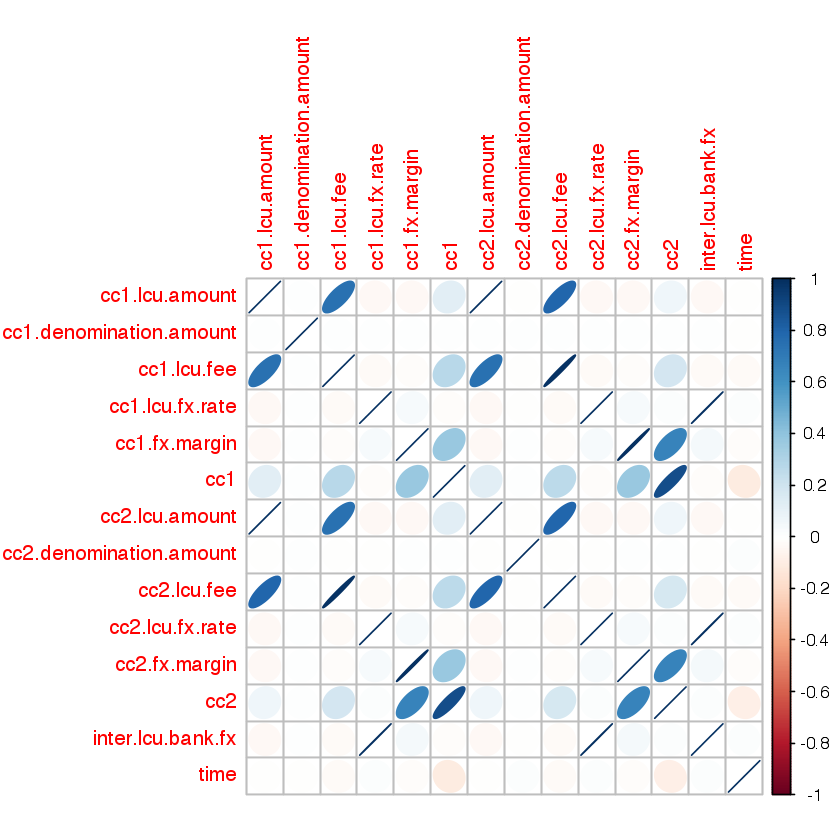

In [78]:
Mcorr <- cor(dfAll[,numVars], use="pairwise.complete.obs")
corrplot(Mcorr, method='ellipse')             

cc1 & cc2 are strongly associated; we see that cc1 correlates positively with cc1.lcu.fee and cc1.fx.margin and has a slightly negative correlation with time

To rank association with factors I will use the mutual information.

<a id='mutinfo'></a>

In [79]:
factorNames <- c('source_code', 'source_name' ,'source_region', 'source_income' ,'source_lending',
                 'source_G8G20' ,'destination_code' ,'destination_name' ,'destination_region', 'destination_income',
                 'destination_lending' ,'destination_G8G20','firm_type' ,'product', 'sending.location' ,
                 'speed.actual','transparent',  'receiving.network.coverage', 'receiving.method' ,'corridor',
                 'payment.instrument', 'sending.network.coverage', 'cash.pickup.location')
MInfo <- data.frame(var = factorNames)
MInfo$cc1Ass <- NA
MInfo$cc2Ass <- NA
for(i in 1:nrow(MInfo)) {
    try ({
        MInfo[i, 'cc1Ass'] <- mi.empirical(table(as.factor(dfAll[,factorNames[i]]),cut(dfAll$cc1,breaks=15)))
        MInfo[i, 'cc2Ass'] <- mi.empirical(table(as.factor(dfAll[,factorNames[i]]),cut(dfAll$cc2,breaks=15)))
    })
}
MInfo %>% arrange(desc(cc1Ass))

Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!Warning message:
In KL.plugin(freqs2d, freqs.null, unit = unit): Vanishing value(s) in argument freqs2!

,var,cc1Ass,cc2Ass
1,corridor,0.403971696727423,0.316326504645039
2,source_code,0.248776792386746,0.161968454417801
3,source_name,0.248776792386746,0.161968454417801
4,destination_code,0.236661288336269,0.179591190594276
5,destination_name,0.236661288336269,0.179591190594276
6,source_region,0.221412241452615,0.201781298591526
7,product,0.119394641483127,0.0580391432784193
8,firm_type,0.0998928163768725,0.0307592614099604
9,source_lending,0.0895735062626399,0.0420541483660324
10,speed.actual,0.0869039130678396,0.0318156466250925


Variables are ranked by association on cc1. We see the importance of corridor (2--6 can be thought of as containing partial info on the corridor) and of product, firm_type, source_lending and speed. With more care one shuld choose different breaks for the factors were a warning sign was issued.